### SVM supplementary example

In this example we will implement SVM classification using linear and Gaussian kernel.

This example has been adapted from <a herf="https://pythonprogramming.net/soft-margin-kernel-cvxopt-svm-machine-learning-tutorial/">pythonprogramming.net</a>

In [2]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
import pylab as pl

Define linear, polynomial and Gaussian kernel.

In [3]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

Define **fit** function to implement cvxopt using linear, polynomial and Gaussian kernel. 

Here the C hyperparameter controls the level of misclassification in SVM optimization. So the C hypermeter which is set before the training model and used to control error, a very small value of C will cause the optimizer to look for a larger-margin (soft margin) separating hyperplane, even if that hyperplane misclassifies more datapairs.

Here **a** are the Lagrange multipliers and **sv** are the support vectors.


In [4]:

def fit(X, y, kernel, C):
    n_samples, n_features = X.shape

    # Gram matrix
    # initialize kernel matrix    
    K = np.zeros((n_samples, n_samples))
    # Kernel matrix
    
    for i in range(n_samples):
        for j in range(n_samples):
            if kernel == 'linear_kernel':
                K[i,j] = linear_kernel(X[i], X[j])
            elif kernel == 'polynomial_kernel':
                K[i,j] = polynomial_kernel(X[i], X[j])
            else:
                K[i,j] = gaussian_kernel(X[i], X[j])
            
     
    P = cvxopt.matrix(np.outer(y,y) * K)
    q = cvxopt.matrix(np.ones(n_samples) * -1)
    A = cvxopt.matrix(y, (1,n_samples))
    b = cvxopt.matrix(0.0)

    if C is None:
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h = cvxopt.matrix(np.zeros(n_samples))
    else:
        tmp1 = np.diag(np.ones(n_samples) * -1)
        tmp2 = np.identity(n_samples)
        G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
        tmp1 = np.zeros(n_samples)
        tmp2 = np.ones(n_samples) * C
        h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

    # solve QP problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # Lagrange multipliers
    a = np.ravel(solution['x'])

    # Support vectors have non zero lagrange multipliers
    sv_idx = a > 1e-5
    ind = np.arange(len(a))[sv_idx]
    a = a[sv_idx]    
    sv = X[sv_idx]
    sv_y = y[sv_idx]
    print("%d support vectors out of %d points" % (len(a), n_samples))

    # Intercept
    b = 0
    for n in range(len(a)):
        b += sv_y[n]
        b -= np.sum(a * sv_y * K[ind[n],sv_idx])
    b /= len(a)

    # Weight vector
    if kernel == 'linear_kernel':
        w = np.zeros(n_features)
        for n in range(len(a)):
            w += a[n] * sv_y[n] * sv[n]
    else:
        w = None
    return sv, sv_y, a, w, b


 Define **project** and **predict** function.

In [5]:
def project(X, kernel,sv, sv_y, a, w, b):
    if w is not None:
        return np.dot(X, w) + b
    else:
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a_val, sv_y_val, sv_val in zip(a, sv_y, sv):
                if kernel == 'polynomial_kernel':
                    s += a_val * sv_y_val * polynomial_kernel(X[i], sv_val)
                else:
                    s += a_val * sv_y_val * gaussian_kernel(X[i], sv_val)
            y_predict[i] = s
        return y_predict + b

def predict(X, kernel, sv, sv_y, a, w, b):
    return np.sign(project(X, kernel,sv, sv_y, a, w, b))


In [6]:
def gen_lin_separable_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def gen_non_lin_separable_data():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

def gen_lin_separable_overlap_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[1.5, 1.0], [1.0, 1.5]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

In [7]:
def split_train(X1, y1, X2, y2):
    X1_train = X1[:90]
    y1_train = y1[:90]
    X2_train = X2[:90]
    y2_train = y2[:90]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    return X_train, y_train

def split_test(X1, y1, X2, y2):
    X1_test = X1[90:]
    y1_test = y1[90:]
    X2_test = X2[90:]
    y2_test = y2[90:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_test, y_test

In [8]:
def plot_margin(X1_train, X2_train, w, b, sv):
    def f(x, w, b, c=0):
        # given x, return y such that [x,y] in on the line
        # w.x + b = c
        return (-w[0] * x - b + c) / w[1]

    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(sv[:,0], sv[:,1], s=100, c="g")

    # w.x + b = 0
    a0 = -4; a1 = f(a0, w, b)
    b0 = 4; b1 = f(b0, w, b)
    pl.plot([a0,b0], [a1,b1], "k")

    # w.x + b = 1
    a0 = -4; a1 = f(a0, w, b, 1)
    b0 = 4; b1 = f(b0, w, b, 1)
    pl.plot([a0,b0], [a1,b1], "k--")

    # w.x + b = -1
    a0 = -4; a1 = f(a0, w, b, -1)
    b0 = 4; b1 = f(b0, w, b, -1)
    pl.plot([a0,b0], [a1,b1], "k--")

    pl.axis("tight")
    pl.show()


In [9]:
def plot_contour(X1_train, X2_train, kernel, sv, sv_y, a, w, b):
    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(sv[:,0], sv[:,1], s=100, c="g")
    # here we choose the range between -7 and 7 as we have choosen
    # the mean to be between -4 and 4 while generating data with the variance of 0.8
    X1, X2 = np.meshgrid(np.linspace(-7,7,50), np.linspace(-7,7,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = project(X, kernel,sv, sv_y, a, w, b).reshape(X1.shape)
    pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

    pl.axis("tight")
    pl.show()

In [10]:
def test_linear():
    X1, y1, X2, y2 = gen_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    kernel = 'linear_kernel'
    C = None
    sv, sv_y, a, w, b = fit(X_train, y_train,kernel, C)

    y_predict = predict(X_test,kernel,sv, sv_y, a, w, b)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_margin(X_train[y_train==1], X_train[y_train==-1], w, b, sv)

def test_non_linear():
    X1, y1, X2, y2 = gen_non_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    kernel = 'gaussian_kernel'
    C = None
    sv, sv_y, a, w, b = fit(X_train, y_train,kernel, C)
    y_predict = predict(X_test,kernel,sv, sv_y, a, w, b)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train==-1], kernel, sv, sv_y, a, w, b)

def test_soft():
    X1, y1, X2, y2 = gen_lin_separable_overlap_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    kernel = 'linear_kernel'
    C=1000.1
    sv, sv_y, a, w, b = fit(X_train, y_train,kernel, C)
    y_predict = predict(X_test,kernel,sv, sv_y, a, w, b)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train==-1], kernel, sv, sv_y, a, w, b)


     pcost       dcost       gap    pres   dres
 0: -1.5760e+01 -2.8655e+01  6e+02  3e+01  2e+00
 1: -1.1588e+01 -6.1153e+00  1e+02  5e+00  3e-01
 2: -1.8130e+00 -2.8172e+00  3e+01  1e+00  7e-02
 3: -2.2224e-01 -2.1877e+00  2e+00  2e-16  2e-15
 4: -9.0509e-01 -1.7796e+00  9e-01  2e-16  2e-15
 5: -1.4852e+00 -1.7630e+00  3e-01  7e-16  2e-15
 6: -1.6999e+00 -1.7031e+00  3e-03  2e-16  2e-15
 7: -1.7023e+00 -1.7024e+00  3e-05  2e-16  2e-15
 8: -1.7024e+00 -1.7024e+00  3e-07  2e-15  2e-15
Optimal solution found.
3 support vectors out of 180 points
20 out of 20 predictions correct


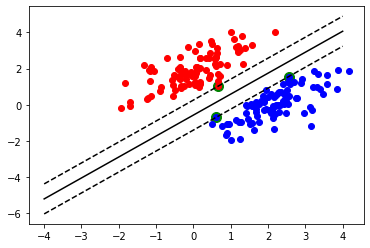

In [11]:
test_linear()

     pcost       dcost       gap    pres   dres
 0: -5.6027e+01 -1.5304e+02  4e+02  2e+01  2e+00
 1: -8.5219e+01 -1.7760e+02  2e+02  6e+00  7e-01
 2: -1.3159e+02 -2.1007e+02  1e+02  3e+00  3e-01
 3: -1.6183e+02 -2.3956e+02  1e+02  2e+00  2e-01
 4: -1.9882e+02 -2.2150e+02  3e+01  5e-01  5e-02
 5: -2.0683e+02 -2.1286e+02  6e+00  3e-02  3e-03
 6: -2.1144e+02 -2.1160e+02  2e-01  5e-04  6e-05
 7: -2.1156e+02 -2.1157e+02  8e-03  1e-05  1e-06
 8: -2.1156e+02 -2.1156e+02  6e-04  8e-08  8e-09
 9: -2.1156e+02 -2.1156e+02  4e-05  1e-10  1e-11
Optimal solution found.
10 support vectors out of 180 points
19 out of 20 predictions correct


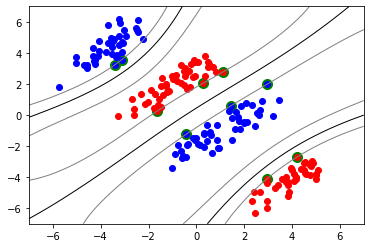

In [12]:
test_non_linear()

     pcost       dcost       gap    pres   dres
 0:  1.5840e+05 -7.8578e+07  2e+08  5e-01  9e-12
 1:  4.2483e+05 -1.2855e+07  2e+07  4e-02  1e-11
 2:  2.4711e+05 -2.2386e+06  3e+06  4e-03  6e-12
 3:  1.4634e+04 -3.1798e+05  3e+05  2e-04  5e-12
 4: -5.8843e+03 -3.1994e+04  3e+04  9e-06  6e-12
 5: -6.9638e+03 -3.2138e+04  3e+04  8e-06  6e-12
 6: -6.4648e+03 -3.1022e+04  2e+04  7e-06  7e-12
 7: -7.1962e+03 -2.1558e+04  1e+04  4e-06  6e-12
 8: -7.6524e+03 -1.4592e+04  7e+03  1e-06  6e-12
 9: -8.7393e+03 -1.5319e+04  7e+03  1e-06  6e-12
10: -8.2063e+03 -1.4733e+04  7e+03  1e-06  6e-12
11: -9.1845e+03 -1.2487e+04  3e+03  4e-07  6e-12
12: -9.1276e+03 -1.2429e+04  3e+03  4e-07  7e-12
13: -9.7480e+03 -1.2328e+04  3e+03  2e-07  7e-12
14: -1.0050e+04 -1.1738e+04  2e+03  1e-07  7e-12
15: -9.9482e+03 -1.1420e+04  1e+03  6e-08  7e-12
16: -9.9676e+03 -1.1405e+04  1e+03  5e-08  7e-12
17: -1.0146e+04 -1.1178e+04  1e+03  3e-08  8e-12
18: -1.0428e+04 -1.0667e+04  2e+02  6e-09  8e-12
19: -1.0488e+04 -1.05

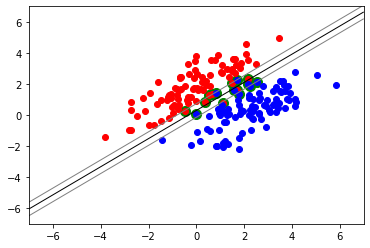

In [13]:
test_soft()